In [1]:
import pandas as pd
import argparse
import logging
import json
import os
import pathlib
import fiona
import numpy as np
import geopandas as gpd
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from geopandas.tools import geocode
from shapely.geometry import Point
import requests
from zipfile import ZipFile
from tqdm import trange, tqdm

#import geojson

In [2]:
def get_commune_egids(BLDG_DIRECTORY, canton, commune, ZIP_URL):

    # downloading the list of EGIDs of a commune.
    # the commune must be specified using the federal numbering system (e.g. 5192 is Lugano)
    print("Downloading data from Swiss official commune register for", commune, "(BFS gemeinde-nummer)")
    url = "%s/%s/%s.zip" % (ZIP_URL, canton, commune)

    zip_name = commune + ".zip"
    file_name = commune + ".csv"
    downloaded_file = BLDG_DIRECTORY / zip_name
    downloaded_file.write_bytes(requests.get(url).content)
    print(downloaded_file)
    

    with ZipFile(downloaded_file,'r') as z:
         
        #parsing the downloaded .csv file
        with z.open(file_name) as f:
            commune_rea = pd.read_csv(f, sep=';')
            #print(commune_rea.head())
            
            commune_egid_clean = commune_rea['EGID']

            # deleting duplicated entries
            i = commune_egid_clean.duplicated(keep='first')
            commune_egid_dirty = commune_egid_clean.loc[i]
            commune_egid_dirty.reset_index(drop=True, inplace=True)
            commune_egid_clean.drop_duplicates(keep=False, inplace=True)
            
            return commune_egid_clean, commune_egid_dirty

In [3]:
def group_clean_list(list_clean, n=20):
    # creating a list for the lookup by FEATURE_ID. The entries are grouped by 20 EGIDs (max number on the server per
    # request). The FEATURE_ID is usually the EGID followed by the suffix "_0"
    temp = []
    for index, value in list_clean.items():
        temp.append(str(value) + '_0')

    list_clean_grouped = []
    for x in range(0, int(list_clean.count()), n):
        list_clean_grouped.append(','.join(temp[x:x + n]))

    return list_clean_grouped

In [4]:
def download_clean_list(list_clean_grouped, list_dirty, API_URL, DATA_LAYER):
    # downloading data by group of EGIDs
    print("Downloading data of 'clean' EGIDs")

    for index in trange(0, len(list_clean_grouped)):
        feature_id = list_clean_grouped[index]
        url = "%s/%s/%s" % (API_URL, DATA_LAYER, feature_id)
        res = requests.get(url)

        if res.status_code == 200:
            temp = json.loads(res.text)
            # jprint(temp)

            if not 'features' in temp or len(temp['features']) == 0:
                print("No data was retrieved. Please enter different inputs")
                #print('\nProgram ended')
                #exit()
        elif res.status_code == 404:

            while res.status_code == 404:
                # extrapolating the problematic EGID
                i_a = res.text.find('id')+3
                i_b = res.text.rfind("_")+2
                i_c = res.text.rfind("_")
                egid_id = res.text[i_a:i_b]

                egid_id.strip()
                list_dirty.loc[list_dirty.count()] = res.text[i_a:i_c]

                feature_id = feature_id.replace(egid_id + ',', '')
                feature_id = feature_id.replace(',' + egid_id, '')

                url = "%s/%s/%s" % (API_URL, DATA_LAYER, feature_id)
                res = requests.get(url)


        else:
            print(res.status_code)

        url = "%s/%s/%s?geometryFormat=geojson" % (API_URL, DATA_LAYER, feature_id)
        res = requests.get(url)
        temp = json.loads(res.text)
        # print(temp)
        temp_gdf = gpd.GeoDataFrame.from_features(temp)
        # print(temp_gdf)

        if index < 1:
            gdf = temp_gdf.copy()
        else:
            gdf = pd.concat([gdf,temp_gdf],ignore_index=True)

    list_dirty.drop_duplicates(keep='first', inplace=True)
    gdf.reset_index(drop=True, inplace=True)

    return gdf, list_dirty

In [5]:
def download_dirty_list(list_dirty, gdf, commune,API_URL, DATA_LAYER, SRC_FIELD):

    # downloading data by single EGID (for problematic entries)
    print("Downloading data of 'dirty' EGIDs (names that needed post-processing for retrieval)")

    with tqdm(total=list_dirty.count()) as pbar:
        for index, value in list_dirty.items():
            src_text = str(value)
            main_url = "%s/find?layer=%s&searchText=%s&searchField=%s&geometryFormat=geojson" % (API_URL, DATA_LAYER, src_text, SRC_FIELD)
            param_url = "&contains=false" #% c.SR
            url = main_url + param_url
            # print(url)
            res = requests.get(url)
            temp = json.loads(res.text)
            temp['type'] = "FeatureCollection"
            temp['features'] = temp['results']

            # jprint(temp['features'])
            if len(temp['results']) > 0:
                temp_gdf = gpd.GeoDataFrame.from_features(temp["features"])
                gdf = pd.concat([gdf,temp_gdf],ignore_index=True)

            pbar.update(1)

    gdf.reset_index(drop=True, inplace=True)
    gdf.set_crs(crs='epsg:2056', inplace=True)

    print("Download ended")

    return gdf

In [6]:
def gdf_to_file(gdf, commune,  BLDG_DIRECTORY):

    name_json = "raw-gdf-"+str(commune) +".geojson"
    filename_json = BLDG_DIRECTORY / name_json
    gdf_json = gdf.to_json(indent=4)

    with open(filename_json, "w") as text_file:
        text_file.write(gdf_json)

    name_csv = "raw-gdf-"+str(commune) +".csv"
    filename_csv = BLDG_DIRECTORY / name_csv
    gdf.to_csv(filename_csv)

    print("The dataframe containing the raw data was written to:", filename_json)

    return gdf

In [7]:
def filter_bldg_type_district(bldgs, gklas, gstat):
    bldg_res = bldgs.loc[((bldgs["gklas"]== gklas) & (bldgs["gstat"]== 1004))]
    return bldg_res

In [8]:
def get_PV_pot_bldgid(building_id):
    TOT_DATA = pd.DataFrame()
    url = 'https://api3.geo.admin.ch//rest/services/api/MapServer/find?'
    params = dict(
        layer='ch.bfe.solarenergie-eignung-daecher',
        searchField='building_id',
        searchText= building_id,
        contains='false'
    )

    # Fetch data using requests
    res = requests.get(url, params=params) 
    temp = json.loads(res.text)
    temp_3 = pd.DataFrame.from_dict(temp, orient="index")
    for i in range(len(temp_3.T)):
        POT_bldg_PV_data =  pd.DataFrame.from_dict(temp_3.iat[0,i],orient="index")
        POT_attributes = POT_bldg_PV_data.loc["attributes"].to_dict()
        POT_attr = pd.DataFrame.from_dict(POT_attributes).T
        
        POT_attr = POT_attr[['building_id', 'bedarf_heizung', 'bedarf_warmwasser', 'dg_heizung', 'dg_waermebedarf', 'flaeche_kollektoren', 'volumen_speicher', 'waermeertrag','klasse', 'flaeche', 'ausrichtung', 'stromertrag',  'df_nummer','neigung', 'label']]
        
        POT_attr = POT_attr.rename(columns ={'building_id':'building_id', 'bedarf_heizung':'demand_heating', 'bedarf_warmwasser':'demand_hot_water','dg_heizung':'percent_of_heating', 'dg_waermebedarf':'percent_of_thermaldemand',
                                             'flaeche_kollektoren':'area_collectors', 'volumen_speicher':'volume_storage', 'waermeertrag':'heat_output', 'klasse':'class', 'flaeche':'area', 'ausrichtung':'alignment', 
                                             'stromertrag':'electricity_yield',  'df_nummer':'df_nummer','neigung': 'inclination', 'label':'label'})
        
        POT_attr = POT_attr.set_index('label')
        TOT_DATA = pd.concat([TOT_DATA, POT_attr])
    
    return TOT_DATA

In [9]:
def get_PV_pot_coords(coords):
    #print(coords)
    url = 'https://api3.geo.admin.ch/rest/services/api/MapServer/identify?'
    params = dict(
        lang= "en",
        sr='2056',
        geometryType='esriGeometryPoint',
        geometry=coords,
        imageDisplay='0,0,0',
        mapExtent='0,0,0,0',
        tolerance='0',
        limit=10,
        returnGeometry ="false",
        layers='all:ch.bfe.solarenergie-eignung-daecher'

    )

    # Fetch data using requests
    res = requests.get(url, params=params) 
    temp = json.loads(res.text)
    #print(temp)
    
    temp_2 = pd.DataFrame.from_dict(temp, orient="columns")
    temp_2.reset_index()

    bldg_PV_data =  pd.DataFrame.from_dict(temp_2.iat[0,0],orient="index")
    bldg_PV_data = bldg_PV_data.rename(columns = {0:"results"})
    #print(bldg_PV_data)
    
    if bldg_PV_data.loc["featureId","results"] == -99:
        #print("no feature at this coordinate")  
        data_fill = [-99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99, -99,  -99, -99, -99]
        PV_POT_attr_filter = pd.DataFrame(data_fill).T
        PV_POT_attr_filter.columns = ['building_id', 'bedarf_heizung', 'bedarf_warmwasser',  'dg_heizung', 'dg_waermebedarf', 'flaeche_kollektoren', 'volumen_speicher', 'waermeertrag', 
                                         'klasse', 'flaeche', 'ausrichtung', 'stromertrag',  'df_nummer','neigung', 'label']

        PV_POT_attr_filter = PV_POT_attr_filter.rename(columns ={'building_id':'building_id', 'bedarf_heizung':'demand_heating', 'bedarf_warmwasser':'demand_hot_water','dg_heizung':'percent_of_heating', 'dg_waermebedarf':'percent_of_thermaldemand', 'flaeche_kollektoren':'area_collectors', 
                     'volumen_speicher':'volume_storage', 'waermeertrag':'heat_output', 'klasse':'class', 'flaeche':'area', 'ausrichtung':'alignment', 
                     'stromertrag':'electricity_yield',  'df_nummer':'df_nummer','neigung': 'inclination', 'label':'label'})
        
        PV_POT_attr_filter =  PV_POT_attr_filter.set_index('label')
    else:
        attributes = bldg_PV_data.loc["attributes"].to_dict()
        PV_POT_attr = pd.DataFrame.from_dict(attributes).T

        PV_POT_attr_filter = PV_POT_attr[['building_id', 'bedarf_heizung', 'bedarf_warmwasser',  'dg_heizung', 'dg_waermebedarf', 'flaeche_kollektoren', 'volumen_speicher', 'waermeertrag', 
                                         'klasse', 'flaeche', 'ausrichtung', 'stromertrag',  'df_nummer','neigung', 'label']]

        PV_POT_attr_filter = PV_POT_attr_filter.rename(columns ={'building_id':'building_id', 'bedarf_heizung':'demand_heating', 'bedarf_warmwasser':'demand_hot_water','dg_heizung':'percent_of_heating', 'dg_waermebedarf':'percent_of_thermaldemand', 'flaeche_kollektoren':'area_collectors', 
                     'volumen_speicher':'volume_storage', 'waermeertrag':'heat_output', 'klasse':'class', 'flaeche':'area', 'ausrichtung':'alignment', 
                     'stromertrag':'electricity_yield',  'df_nummer':'df_nummer','neigung': 'inclination', 'label':'label'})
        PV_POT_attr_filter = PV_POT_attr_filter.set_index("label")
        #PV_POT_attr_filter = PV_POT_attr_filter.drop(["index"])
        
    #print(PV_POT_attr_filter) 
    return PV_POT_attr_filter

In [10]:
# Define constants
EPSG_CODE = "EPSG:2056"
BUFFER_DISTANCE = 5
GKLAS_SFH = 1110
GKLAS_DFH = 1121
GKLAS_MFH = 1122
GKLAS_RES = [GKLAS_SFH, GKLAS_DFH, GKLAS_MFH]
GBAUP = [8011,8012,8013,8014,8015,8016,8017,8018,8019,8020,8021,8022,8023]
GSTAT = 1004 # existing
#DISTRICT = "Bellinzona"
#MUNICIPALITIES = ["Arbedo-Castione", "Bellinzona", "Cadenazzo", "Isone", "Lumino","Sant'Antonino"]

REA_CODES_DESIRED_CC = ['EGID', 'GKODE', 'GKODN',
                           'GSTAT', 'GKAT', 'GKLAS', 'GBAUJ', 'GBAUP', 'GRENJ', 'GABBJ', 'GAREA','GASTW', 
                           'GWAERZH1', 'GENH1', 'GWAERDATH1', 'GWAERZH2', 'GENH2', 'GWAERDATH2', 
                           'GWAERZW1', 'GENW1', 'GWAERDATW1','GWAERZW2', 'GENW2', 'GWAERDATW2', 
                           'Create_Date','Update_Date', 'GGDENR', 'GDENAME', 'GDEKT']

#REA_CODES_DESIRED_LC = REA_CODES_DESIRED_CC
#for i in range(len(REA_CODES_DESIRED_CC)):
#    REA_CODES_DESIRED_LC[i] = REA_CODES_DESIRED_LC[i].lower()

In [23]:
pathlib.Path()
NOTEBOOK_PATH = pathlib.Path().resolve()
p = NOTEBOOK_PATH.parent
DATA_DIRECTORY = p / "data"
MAP_DIRECTORY = DATA_DIRECTORY /'maps'
BLDG_DIRECTORY = DATA_DIRECTORY /'Buildings_rea'

#SELECT CANTON
CANTON = "Genève"

# Read the shp file and decode the Geopandas dataframe using the Swiss coordinates (epsg code: 2056)
SWISSTOPO_DISTRICT_FILE = "swissboundaries3d_2023-01_2056_5728.shp/swissBOUNDARIES3D_1_4_TLM_BEZIRKSGEBIET.shp" #shapefile downloaded from https://www.swisstopo.admin.ch/fr/geodata/landscape/boundaries3d.html
SWISSTOPO_CANTON_FILE = "swissboundaries3d_2023-01_2056_5728.shp/swissBOUNDARIES3D_1_4_TLM_KANTONSGEBIET.shp" #shapefile downloaded from https://www.swisstopo.admin.ch/fr/geodata/landscape/boundaries3d.html. NOTE: The actual shapefile (.shp) is useless without the companion files: .dbf, .shx, .prj etc..
### SWISSTOPO_CANTON_FILE = figureout how to get the municipal boundaries https://api3.geo.admin.ch/rest/services/api/MapServer/ch.swisstopo.swissboundaries3d-gemeinde-flaeche.fill

CANTON_FILE_PATH = MAP_DIRECTORY / SWISSTOPO_CANTON_FILE
DISTRICT_FILE_PATH = MAP_DIRECTORY / SWISSTOPO_DISTRICT_FILE

CANTON_CSV_DIRECTORY = BLDG_DIRECTORY / CANTON

# Read the gpkg file and decode the Geopandas dataframe using the Swiss coordinates (epsg code: 2056)
PLANT_DIRECTORY = DATA_DIRECTORY /'ElectricityProduction_EPSG2056'

In [ ]:
# NOT USED 
#Read the gpkg file and decode the Geopandas dataframe using the Swiss coordinates (epsg code: 2056)
BLG_DIRECTORY = DATA_DIRECTORY /'Buildings_rea'

comune_zip = commune + ".zip"
comune_csv = commune + ".csv"
ZIP_FILE_DIRECTORY = BLG_DIRECTORY / comune_zip
CSV_FILE_DIRECTORY = BLG_DIRECTORY / comune_zip / comune_csv

with ZipFile(ZIP_FILE_DIRECTORY) as z:
    b = z.open(comune_csv)
    bldgs_raw = pd.read_csv(b, sep=";")
    print (bldgs_raw.columns)


### Read Canton file

In [25]:
raw_limits = gpd.read_file(CANTON_FILE_PATH)
canton_limits = raw_limits.to_crs(epsg=2056)
canton_selection = canton_limits[canton_limits.NAME == CANTON]
canton_selection = canton_selection[["NAME", "geometry"]]
canton_selection= canton_selection.reset_index()
canton_selection.at[0,"geometry"]
print(canton_selection)

   index    NAME                                           geometry
0     20  Genève  POLYGON Z ((2487005.785 1113215.899 347.190, 2...
1     35  Genève  POLYGON Z ((2504115.330 1133243.816 405.654, 2...
2     44  Genève  POLYGON Z ((2503449.480 1133491.108 441.454, 2...


In [28]:
## double checking raw data - according to SIG - 2860 PV plants in Geneve: https://ww2.sig-ge.ch/particuliers/offres/solaire/offres-solaires
plants =  gpd.read_file(PLANT_DIRECTORY / "ElectricityProductionPlants.gpkg") #file downloaded from https://www.geocat.ch/geonetwork/srv/eng/catalog.search#/metadata/e5a00bdb-5022-4856-ad4a-d1afe7bf38b0
PV_DATA = pd.DataFrame()

for i in range(len(canton_selection)):
    plants_in_district = plants[plants.within(canton_selection.at[i,"geometry"])]
    #print(plants_in_district.head())
    PV_DATA = pd.concat([PV_DATA, plants_in_district],ignore_index=True)
    #print(PV_DATA)
    
PV_plants_in_canton = PV_DATA.loc[PV_DATA["SubCategory"]== "subcat_2"]
print(len(PV_plants_in_canton))


4013


In [29]:
PV_plants_in_canton.head()
#PV_plants_in_canton.crs

,xtf_id,Address,PostCode,Municipality,Canton,BeginningOfOperation,InitialPower,TotalPower,MainCategory,SubCategory,PlantCategory,geometry
0,17053,Chemin du Pré Gabet 38,1288,Aire-la-Ville,GE,2012-02-27,3.9,3.9,maincat_2,subcat_2,plantcat_9,POINT (2492190.000 1116266.000)
1,30996,Route de Soral 104 bis,1233,Bernex,GE,2010-01-04,8.9,8.9,maincat_2,subcat_2,plantcat_8,POINT (2494837.000 1113715.000)
2,12888,Avenue de Feuillasse 24,1217,Meyrin,GE,2007-07-18,654.8,654.8,maincat_2,subcat_2,plantcat_8,POINT (2495389.000 1121004.000)
3,12469,Route de l'Allondon 31,1242,Satigny,GE,2009-10-29,41.9,41.9,maincat_2,subcat_2,plantcat_8,POINT (2489897.000 1119004.000)
4,13043,Avenue VIBERT 32,1227,Carouge,GE,2006-04-20,270.4,270.4,maincat_2,subcat_2,plantcat_8,POINT (2499271.000 1115640.000)


### Get REA per comune

In [46]:
ZIP_URL = 'https://data.geo.admin.ch/ch.bfs.gebaeude_wohnungs_register/CSV'
API_URL = 'https://api3.geo.admin.ch/rest/services/api/MapServer'
DATA_LAYER = 'ch.bfs.gebaeude_wohnungs_register'  # REA
SRC_FIELD = 'egid'

canton ="GE"
# TO-DO: WRITE A FUNCTION THAT GETS THE *Numero UST del Comune* for the canton from the file "BUILDING_DIRECTORY/StateComune.xlsx
# GE communes 6601-6045
commune = "6601"
commune_egid_clean, commune_egid_dirty  = get_commune_egids(BLDG_DIRECTORY, canton, commune, ZIP_URL)
commune_egid_clean_grouped = group_clean_list(commune_egid_clean)
gdf, commune_egid_dirty = download_clean_list(commune_egid_clean_grouped, commune_egid_dirty, API_URL, DATA_LAYER)
gdf = download_dirty_list(commune_egid_dirty, gdf, commune,API_URL, DATA_LAYER, SRC_FIELD)
gdf_to_file(gdf, commune, BLDG_DIRECTORY)

C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\6601.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:06<00:00,  3.34it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.48it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-6601.geojson


,geometry,egid,strname_deinr,plz_plz6,ggdename,ggdenr,gexpdat,gdekt,egrid,lgbkr,...,weinr,wbez,wstat,wexpdat,wbauj,wabbj,warea,wazim,wkche,label
0,POINT (492430.900 115937.000),1631457,Route du Moulin-de-la-Ratte 24,1288/128800,Aire-la-Ville,6601,22.05.2023,GE,CH728226656395,1,...,[None],[None],[3004],[2023-05-22T00:00:00],[1999],[None],[150],[5],[1],Route du Moulin-de-la-Ratte 24
1,POINT (492424.300 115926.100),1631458,Route du Moulin-de-la-Ratte 26,1288/128800,Aire-la-Ville,6601,22.05.2023,GE,CH136582636184,1,...,[None],[None],[3004],[2023-05-22T00:00:00],[1999],[None],[None],[8],[1],Route du Moulin-de-la-Ratte 26
2,POINT (492416.800 115911.000),1631459,Route du Moulin-de-la-Ratte 28,1288/128800,Aire-la-Ville,6601,22.05.2023,GE,CH746365822681,1,...,[None],[None],[3004],[2023-05-22T00:00:00],[1999],[None],[120],[5],[1],Route du Moulin-de-la-Ratte 28
3,POINT (492397.500 115931.900),1631460,Route du Moulin-de-la-Ratte 30,1288/128800,Aire-la-Ville,6601,22.05.2023,GE,CH776382666582,1,...,[None],[None],[3004],[2023-05-22T00:00:00],[1999],[None],[200],[7],[1],Route du Moulin-de-la-Ratte 30
4,POINT (492393.600 115918.200),1631461,Route du Moulin-de-la-Ratte 32,1288/128800,Aire-la-Ville,6601,22.05.2023,GE,CH208263536531,1,...,[None],[None],[3004],[2023-05-22T00:00:00],[1999],[None],[120],[4],[1],Route du Moulin-de-la-Ratte 32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,POINT (492168.200 116294.000),3131307,Chemin du Pré-Gabet 10,1288/128800,Aire-la-Ville,6601,22.05.2023,GE,CH246365843641,1,...,[None],[None],[3004],[2023-05-22T00:00:00],[1999],[None],[100],[3],[1],Chemin du Pré-Gabet 10
439,POINT (492278.200 116361.200),1631588,Chemin du Facteur 10,1288/128800,Aire-la-Ville,6601,22.05.2023,GE,CH636585638656,1,...,None,None,None,None,None,None,None,None,None,Chemin du Facteur 10
440,POINT (492272.300 116357.400),1631588,Chemin du Facteur 8,1288/128800,Aire-la-Ville,6601,22.05.2023,GE,CH636585638656,1,...,"[None, None]","[None, None]","[3004, 3004]","[2023-05-22T00:00:00, 2023-05-22T00:00:00]","[1999, 2013]","[None, None]","[182, 160]","[4, 5]","[1, 1]",Chemin du Facteur 8
441,POINT (492247.400 116395.800),2033858,Rue du Vieux-Four 37,1288/128800,Aire-la-Ville,6601,22.05.2023,GE,CH996583796343,1,...,[None],[None],[3004],[2023-05-22T00:00:00],[1999],[None],[None],[3],[1],Rue du Vieux-Four 37


EGID
L’identificatore federale dell’edificio (EGID) è il numero di identificazione dell’e¬dificio in cui la persona vive ed è determinato dall’indirizzo.  L’EGID è generato dal REA e permette un’identificazione univoca dell’edificio in tutta la Svizzera.

EWID
L’identificatore federale dell’abitazione (EWID) è il numero di identificazione dell’abitazione in cui vive la persona. L’EWID è generato dal REA e, insieme all’identificatore federale dell’edificio (EGID), permette un’identificazione univoca dell’abitazione in tutta la Svizzera. Un’abitazione dispone di un’installazione per la cucina (cucina o angolo cottura).

In [15]:
REA_CODES_DESIRED_LC = ['egid', 'strname_deinr', 'ggdename', 'ggdenr',
       'gexpdat', 'gdekt', 'egrid','gebnr', 'gkode', 'gkodn', 'gksce', 'gstat', 'gkat', 'gklas',
       'gbauj', 'gbaup', 'gabbj', 'garea', 'gastw', 'gazzi', 'gebf', 'gwaerzh1',
       'genh1', 'gwaersceh1', 'gwaerdath1', 'gwaerzh2', 'genh2', 'gwaersceh2',
       'gwaerdath2', 'gwaerzw1', 'genw1', 'gwaerscew1', 'gwaerdatw1',
       'gwaerzw2', 'genw2', 'gwaerscew2', 'gwaerdatw2']

#REA_CODES_DESIRED_LC = REA_CODES_DESIRED_CC
#for i in range(len(REA_CODES_DESIRED_CC)):
#    REA_CODES_DESIRED_LC[i] = REA_CODES_DESIRED_LC[i].lower()

## TEST - Get data for a single comune

In [31]:
ZIP_URL = 'https://data.geo.admin.ch/ch.bfs.gebaeude_wohnungs_register/CSV'
API_URL = 'https://api3.geo.admin.ch/rest/services/api/MapServer'
DATA_LAYER = 'ch.bfs.gebaeude_wohnungs_register'  # REA
SRC_FIELD = 'egid'

# problem with 6615 - "Collex-Bossy", 6616 - "Collonge-Bellerive", 6624 - "Gy", 6633 - "Plan-les-Ouates"
canton ="GE"
# TO-DO: WRITE A FUNCTION THAT GETS THE *Numero UST del Comune* for the canton from the file "BUILDING_DIRECTORY/StateComune.xlsx
# GE communes 6601-6645
commune = "6641"
commune_egid_clean, commune_egid_dirty  = get_commune_egids(BLDG_DIRECTORY, canton, commune, ZIP_URL)
#commune_egid_clean_grouped = group_clean_list(commune_egid_clean)
#gdf, commune_egid_dirty = download_clean_list(commune_egid_clean_grouped, commune_egid_dirty, API_URL, DATA_LAYER)
#gdf = download_dirty_list(commune_egid_dirty, gdf, commune,API_URL, DATA_LAYER, SRC_FIELD)
#gdf_to_file(gdf, commune, BLDG_DIRECTORY)

C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\6641.zip


In [32]:
commune_egid_clean.head()

0    1027196
1    1027197
2    1027198
3    1027199
4    1027201
Name: EGID, dtype: int64

In [33]:
print(type(commune_egid_clean))

<class 'pandas.core.series.Series'>


In [46]:
commune_egid_clean_grouped = group_clean_list(commune_egid_clean)

## if test sucessful - run script to get data for all comunes of a desired cantone

In [30]:
ZIP_URL = 'https://data.geo.admin.ch/ch.bfs.gebaeude_wohnungs_register/CSV'
API_URL = 'https://api3.geo.admin.ch/rest/services/api/MapServer'
DATA_LAYER = 'ch.bfs.gebaeude_wohnungs_register'  # REA
SRC_FIELD = 'egid'


SFH_csv_name = "bldg_SFH_PV_EGID.csv"
DFH_csv_name = "bldg_DFH_PV_EGID.csv"
MFH_csv_name = "bldg_MFH_PV_EGID.csv"


TOT = pd.DataFrame()
REA_DATA = pd.DataFrame()
PV_plants_geo = PV_plants_in_canton.copy()
PV_plants_geo['geometry'] = PV_plants_geo['geometry'].buffer(5)

canton ="GE"
# TO-DO: WRITE A FUNCTION THAT GETS THE *Numero UST del Comune* for the canton from the file "BUILDING_DIRECTORY/StateComune.xlsx
# GE communes 6601-6645
# problem with 6615 - "Collex-Bossy", 6616 - "Collonge-Bellerive", 6624 - "Gy", 6633 - "Plan-les-Ouates"

for commune_num in range(6634,6646,1):
    commune = str(commune_num)
    #print(commune)
    
    commune_tocsv = commune +"_"
    
    commune_SFH_csv = commune_tocsv + SFH_csv_name
    commune_DFH_csv = commune_tocsv + DFH_csv_name
    commune_MFH_csv = commune_tocsv + MFH_csv_name

    csv_names = [commune_SFH_csv, commune_DFH_csv, commune_MFH_csv]
    
    commune_egid_clean, commune_egid_dirty  = get_commune_egids(BLDG_DIRECTORY, canton, commune, ZIP_URL)
    commune_egid_clean_grouped = group_clean_list(commune_egid_clean)
    gdf, commune_egid_dirty = download_clean_list(commune_egid_clean_grouped, commune_egid_dirty, API_URL, DATA_LAYER)
    gdf = download_dirty_list(commune_egid_dirty, gdf, commune,API_URL, DATA_LAYER, SRC_FIELD)
    gdf_to_file(gdf, commune, BLDG_DIRECTORY)

    bldgs = gdf[REA_CODES_DESIRED_LC]


    #geopanda - create points geometry from GKODE and GKODN
    bldg_geo = gpd.GeoDataFrame(bldgs, geometry=gpd.points_from_xy(bldgs.gkode, bldgs.gkodn))
    #bldg_geo = gpd.GeoDataFrame(bldgs)

    # call function filter_bldg_type_district to get the buildings
    bldg_district_SFH = filter_bldg_type_district(bldg_geo, GKLAS_SFH, GSTAT)
    bldg_district_DFH = filter_bldg_type_district(bldg_geo, GKLAS_DFH, GSTAT)
    bldg_district_MFH = filter_bldg_type_district(bldg_geo, GKLAS_MFH, GSTAT)
        

    n=0
    for res_type in (bldg_district_SFH, bldg_district_DFH, bldg_district_MFH):
        csv_name = csv_names[n]
        #print(csv_name)

        bldg_PP = res_type.copy()
        bldg_PP = bldg_PP[["egid","geometry"]]
        bldg_PP = bldg_PP.set_crs("EPSG:2056")
        bldg_PP = gpd.sjoin(bldg_PP, PV_plants_geo)

        geo = res_type.reset_index()
        # print(geo.head())
    
        ## iterate for each bldg in the bldg type SFH, DFH, MFH and find their roof area and PV potential from the geoadmin.ch site.

        for i in range(len(geo)): ##range(len(geo)) to iterate over all bldgs, otherwise range(5) if only testing that it works
            assert type(geo.loc[i, 'geometry']) == Point, "Your geometry is not of Point type. It is" % type(geo['geometry'])
            coords = str(geo.loc[i, 'geometry'].x) + "," + str(geo.loc[i, 'geometry'].y)
            coords_PV_pot = get_PV_pot_coords(coords)

            if coords_PV_pot.iat[0,0]==-99:
                bldg_PV_pot = coords_PV_pot.reset_index()

            else:
                building_id = str(coords_PV_pot.iat[0,0])
                bldg_PV_pot = get_PV_pot_bldgid(building_id)
                bldg_PV_pot = bldg_PV_pot.reset_index()


            geo_i = geo.loc[[i]]
            geo_i = geo_i.reset_index()
            joint_df = bldg_PV_pot.join(geo_i)
            joint_df["str_geometry"] = joint_df['geometry'].astype(str)
            joint_df_geo = joint_df['geometry']

            drop_list =["index","GBAUJ", "GWAERZH2","GENH2", "GWAERDATH2","GWAERZW2","GENW2","GWAERDATW2","geometry"]
            
            for m in range(len(drop_list)):
                drop_list[m] = drop_list[m].lower()

            joint_df = joint_df.drop(drop_list, axis=1) 
            joint_df = joint_df.ffill(axis="index").bfill(axis="index")
            TOT = pd.concat([TOT,joint_df], ignore_index=True)

        TOT = TOT.join(bldg_PP.set_index('egid'), on='egid', validate='m:m')
        TOT.to_csv(csv_name)
        print("done with: ", csv_name ) 
        n=n+1
        TOT = TOT.drop(['geometry',"index_right","xtf_id","Address","PostCode","Municipality","Canton","BeginningOfOperation","InitialPower","TotalPower","MainCategory","SubCategory","PlantCategory"], axis=1)
        TOT = TOT[0:0]  

C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\6634.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:25<00:00,  3.14it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.17it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-6634.geojson
done with:  6634_bldg_SFH_PV_EGID.csv
done with:  6634_bldg_DFH_PV_EGID.csv
done with:  6634_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\6635.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.73it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.01it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-6635.geojson
done with:  6635_bldg_SFH_PV_EGID.csv
done with:  6635_bldg_DFH_PV_EGID.csv
done with:  6635_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\6636.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:09<00:00,  2.78it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.64it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-6636.geojson
done with:  6636_bldg_SFH_PV_EGID.csv
done with:  6636_bldg_DFH_PV_EGID.csv
done with:  6636_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\6637.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.02it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.71it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-6637.geojson
done with:  6637_bldg_SFH_PV_EGID.csv
done with:  6637_bldg_DFH_PV_EGID.csv
done with:  6637_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\6638.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:16<00:00,  3.75it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 12.15it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-6638.geojson
done with:  6638_bldg_SFH_PV_EGID.csv
done with:  6638_bldg_DFH_PV_EGID.csv
done with:  6638_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\6639.zip


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 12.52it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-6639.geojson
done with:  6639_bldg_SFH_PV_EGID.csv
done with:  6639_bldg_DFH_PV_EGID.csv
done with:  6639_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\6640.zip


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:38<00:00,  3.64it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.59it/s]


Download ended
The dataframe containing the raw data was written to: C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\raw-gdf-6640.geojson
done with:  6640_bldg_SFH_PV_EGID.csv
done with:  6640_bldg_DFH_PV_EGID.csv
done with:  6640_bldg_MFH_PV_EGID.csv
C:\Users\jalomi.maayantardif\GitHub\ace-simulator\data\Buildings_rea\6641.zip


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 49/50 [00:17<00:00,  2.86it/s]


No data was retrieved. Please enter different inputs


TypeError: string indices must be integers

## Putting together REA- PV plants, and PV potential for the problematic communes of Geneve - works !

In [ ]:
ZIP_URL = 'https://data.geo.admin.ch/ch.bfs.gebaeude_wohnungs_register/CSV'
API_URL = 'https://api3.geo.admin.ch/rest/services/api/MapServer'
DATA_LAYER = 'ch.bfs.gebaeude_wohnungs_register'  # REA
SRC_FIELD = 'egid'

SFH_csv_name = "bldg_SFH_PV_EGID.csv"
DFH_csv_name = "bldg_DFH_PV_EGID.csv"
MFH_csv_name = "bldg_MFH_PV_EGID.csv"

TOT = pd.DataFrame()
REA_DATA = pd.DataFrame()
PV_plants_geo = PV_plants_in_canton.copy()
PV_plants_geo['geometry'] = PV_plants_geo['geometry'].buffer(5)

canton ="GE"
# problem with 6615 - "Collex-Bossy", 6616 - "Collonge-Bellerive", 6624 - "Gy", 6633 - "Plan-les-Ouates"
# TO-DO: WRITE A FUNCTION THAT GETS THE *Numero UST del Comune* for the canton from the file "BUILDING_DIRECTORY/StateComune.xlsx
# GE communes 6601-6045
commune_missing = [6615,6616,6624,6633]

for commune_num in commune_missing:
    commune = str(commune_num)
    print(commune)
    
    commune_tocsv = commune +"_"
    
    commune_SFH_csv = commune_tocsv + SFH_csv_name
    commune_DFH_csv = commune_tocsv + DFH_csv_name
    commune_MFH_csv = commune_tocsv + MFH_csv_name

    csv_names = [commune_SFH_csv, commune_DFH_csv, commune_MFH_csv]
    commune_egid_clean, commune_egid_dirty  = get_commune_egids(BLDG_DIRECTORY, canton, commune, ZIP_URL)

    DATA = pd.DataFrame()

    # specify the base URL for the API endpoint
    base_url = "https://api3.geo.admin.ch/rest/services/api/MapServer/find?"

    commune_egid_clean =commune_egid_clean.reset_index()

    for egids in range(len(commune_egid_clean)):
        egid = commune_egid_clean.loc[egids]
        #print("the eigds is ", egid)

        # specify the parameters for the API request
        params = dict(
        layer= "ch.bfs.gebaeude_wohnungs_register",
        searchText= egid,
        searchField= "egid",
        contains="false"
        )

        # make the API request and convert the response to a JSON object
        res = requests.get(base_url, params=params)
        #print (res.status_code)

        if res.status_code == 200:
            temp = json.loads(res.text)
            temp_3 = pd.DataFrame.from_dict(temp, orient="index")

            for s in range(len(temp_3.T)):
                data =  pd.DataFrame.from_dict(temp_3.iat[0,s],orient="index")
                attributes = data.loc["attributes"].to_dict()
                attr = pd.DataFrame.from_dict(attributes).T
               # print(attr["egid"])


        attr = attr.set_index('label')
        DATA = pd.concat([DATA, attr])

    DATA_name = "DATA_"+str(commune)+".csv"

    DATA.to_csv(DATA_name)

    DATA=DATA.reset_index()
    bldgs = DATA[REA_CODES_DESIRED_LC]


    #geopanda - create points geometry from GKODE and GKODN
    bldg_geo = gpd.GeoDataFrame(bldgs, geometry=gpd.points_from_xy(bldgs.gkode, bldgs.gkodn))
    #bldg_geo = gpd.GeoDataFrame(bldgs)

    # call function filter_bldg_type_district to get the buildings
    bldg_district_SFH = filter_bldg_type_district(bldg_geo, GKLAS_SFH, GSTAT)
    bldg_district_DFH = filter_bldg_type_district(bldg_geo, GKLAS_DFH, GSTAT)
    bldg_district_MFH = filter_bldg_type_district(bldg_geo, GKLAS_MFH, GSTAT)


    n=0
    for res_type in (bldg_district_SFH, bldg_district_DFH, bldg_district_MFH):
        csv_name = csv_names[n]
        #print(csv_name)

        bldg_PP = res_type.copy()
        bldg_PP = bldg_PP[["egid","geometry"]]
        bldg_PP = bldg_PP.set_crs("EPSG:2056")
        bldg_PP = gpd.sjoin(bldg_PP, PV_plants_geo)

        geo = res_type.reset_index()
        # print(geo.head())

        ## iterate for each bldg in the bldg type SFH, DFH, MFH and find their roof area and PV potential from the geoadmin.ch site.

        for i in range(len(geo)): ##range(len(geo)) to iterate over all bldgs, otherwise range(5) if only testing that it works
            assert type(geo.loc[i, 'geometry']) == Point, "Your geometry is not of Point type. It is" % type(geo['geometry'])
            coords = str(geo.loc[i, 'geometry'].x) + "," + str(geo.loc[i, 'geometry'].y)
            coords_PV_pot = get_PV_pot_coords(coords)

            if coords_PV_pot.iat[0,0]==-99:
                bldg_PV_pot = coords_PV_pot.reset_index()

            else:
                building_id = str(coords_PV_pot.iat[0,0])
                bldg_PV_pot = get_PV_pot_bldgid(building_id)
                bldg_PV_pot = bldg_PV_pot.reset_index()


            geo_i = geo.loc[[i]]
            geo_i = geo_i.reset_index()
            #print(geo_i)
            #print(bldg_PV_pot)
            joint_df = bldg_PV_pot.join(geo_i)
            joint_df["str_geometry"] = joint_df['geometry'].astype(str)
            joint_df_geo = joint_df['geometry']

            drop_list =["index","GBAUJ", "GWAERZH2","GENH2", "GWAERDATH2","GWAERZW2","GENW2","GWAERDATW2","geometry"]

            for m in range(len(drop_list)):
                drop_list[m] = drop_list[m].lower()

            joint_df = joint_df.drop(drop_list, axis=1) 
            joint_df = joint_df.ffill(axis="index").bfill(axis="index")
            TOT = pd.concat([TOT,joint_df], ignore_index=True)

        TOT = TOT.join(bldg_PP.set_index('egid'), on='egid', validate='m:m')
        TOT.to_csv(csv_name)
        print("done with: ", csv_name ) 
        n=n+1
        TOT = TOT.drop(['geometry',"index_right","xtf_id","Address","PostCode","Municipality","Canton","BeginningOfOperation","InitialPower","TotalPower","MainCategory","SubCategory","PlantCategory"], axis=1)
        TOT = TOT[0:0]  

In [38]:
from pathlib import Path

SFH_TOT = pd.DataFrame()
DFH_TOT = pd.DataFrame()
MFH_TOT = pd.DataFrame()


for commune_num in range(6634,6641,1):
    SFH_csv = str(commune_num) + "_bldg_SFH_PV_EGID.csv"
    DFH_csv = str(commune_num) + "_bldg_DFH_PV_EGID.csv"
    MFH_csv = str(commune_num) + "_bldg_MFH_PV_EGID.csv"
    
    commune_file = Path(CANTON_CSV_DIRECTORY/SFH_csv)
    
    if commune_file.is_file():
        SFH_pd = pd.read_csv(CANTON_CSV_DIRECTORY/SFH_csv)
        DFH_pd = pd.read_csv(CANTON_CSV_DIRECTORY/DFH_csv)
        MFH_pd = pd.read_csv(CANTON_CSV_DIRECTORY/MFH_csv)
        
        SFH_TOT = pd.concat([SFH_TOT,SFH_pd], ignore_index=True) 
        DFH_TOT = pd.concat([DFH_TOT,DFH_pd], ignore_index=True) 
        MFH_TOT = pd.concat([MFH_TOT,MFH_pd], ignore_index=True) 
    
    else:
        print(commune_num, "this file does not exists")  

SFH_TOT.to_csv("GE_SFH.csv")
DFH_TOT.to_csv("GE_DFH.csv")
MFH_TOT.to_csv("GE_MFH.csv")

In [39]:
GE_SFH = pd.read_csv(CANTON_CSV_DIRECTORY/"GE_SFH.csv",  usecols= ['egid', 'gkode','gkodn','str_geometry'])
GE_DFH = pd.read_csv(CANTON_CSV_DIRECTORY/"GE_DFH.csv",  usecols= ['egid', 'gkode','gkodn','str_geometry'])
GE_MFH = pd.read_csv(CANTON_CSV_DIRECTORY/"GE_MFH.csv",  usecols= ['egid', 'gkode','gkodn','str_geometry'])

GE_RES = pd.concat([GE_SFH,GE_DFH ,GE_MFH],ignore_index= True)

In [40]:
GE_RES = GE_RES.drop_duplicates(subset=['egid'])
GE_RES_GEO = gpd.GeoDataFrame(GE_RES, geometry=gpd.points_from_xy(GE_RES.gkode, GE_RES.gkodn))
GE_RES_GEO.head()

,egid,gkode,gkodn,str_geometry,geometry
0,1024010,2499262.00,1122029.50,POINT (2499262 1122029.5),POINT (2499262.000 1122029.500)
6,1024012,2499236.25,1122009.88,POINT (2499236.25 1122009.88),POINT (2499236.250 1122009.880)
12,1024013,2499214.63,1121993.88,POINT (2499214.63 1121993.88),POINT (2499214.630 1121993.880)
14,1024015,2500057.00,1122054.57,POINT (2500057 1122054.57),POINT (2500057.000 1122054.570)
18,1024017,2500069.00,1122055.13,POINT (2500069 1122055.13),POINT (2500069.000 1122055.130)


In [41]:
GE_RES_GEO.dtypes

egid               int64
gkode            float64
gkodn            float64
str_geometry      object
geometry        geometry
dtype: object

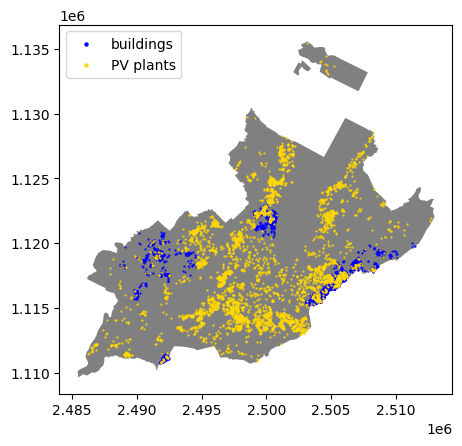

In [42]:
axes = canton_selection.plot(facecolor="grey")
GE_RES_GEO.plot(ax=axes, color="blue",markersize=0.3, label= "buildings")
PV_plants_in_canton.plot(ax=axes, color="gold",markersize=0.3, label="PV plants")
axes.legend(loc="upper left", markerscale=4)

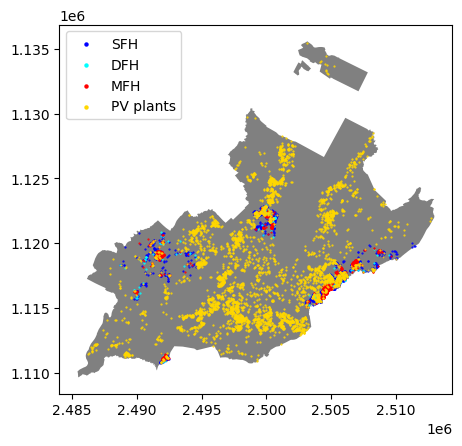

In [43]:
GE_RES_SFH = GE_SFH.drop_duplicates(subset=['egid'])
GE_RES_SFH_GEO = gpd.GeoDataFrame(GE_RES_SFH, geometry=gpd.points_from_xy(GE_RES_SFH.gkode, GE_RES_SFH.gkodn))

GE_RES_DFH = GE_DFH.drop_duplicates(subset=['egid'])
GE_RES_DFH_GEO = gpd.GeoDataFrame(GE_RES_DFH, geometry=gpd.points_from_xy(GE_RES_DFH.gkode, GE_RES_DFH.gkodn))

GE_RES_MFH = GE_MFH.drop_duplicates(subset=['egid'])
GE_RES_MFH_GEO = gpd.GeoDataFrame(GE_RES_MFH, geometry=gpd.points_from_xy(GE_RES_MFH.gkode, GE_RES_MFH.gkodn))

axes = canton_selection.plot(facecolor="grey")
GE_RES_SFH_GEO.plot(ax=axes, color="blue",markersize=0.3, label = "SFH")
GE_RES_DFH_GEO.plot(ax=axes, color="cyan",markersize=0.3, label = "DFH")
GE_RES_MFH_GEO.plot(ax=axes, color="red",markersize=0.3, label = "MFH")
PV_plants_in_canton.plot(ax=axes, color="gold",markersize=0.3,label="PV plants")
axes.legend(loc="upper left", markerscale=4)

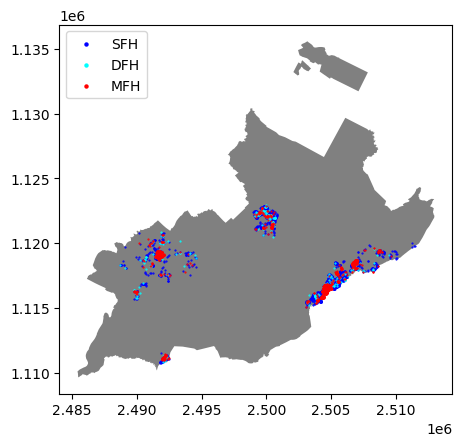

In [44]:
#import matplotlib.pyplot as plt
axes = canton_selection.plot(facecolor="grey")
GE_RES_SFH_GEO.plot(ax=axes, color="blue",markersize=0.3, label = "SFH")
GE_RES_DFH_GEO.plot(ax=axes, color="cyan",markersize=0.3, label = "DFH")
GE_RES_MFH_GEO.plot(ax=axes, color="red",markersize=0.3, label = "MFH")
axes.legend(loc="upper left", markerscale=4)
#PV_plants_in_canton.plot(ax=axes, color="gold",markersize=1)

In [ ]:
DISTRICT = "Bellinzona"
AMB_CSV_DIRECTORY = BLDG_DIRECTORY / DISTRICT
AMB_SFH = pd.read_csv(AMB_CSV_DIRECTORY/"AMB_SFH.csv",  usecols= ['EGID', 'GKODE','GKODN','str_geometry'])
AMB_DFH = pd.read_csv(AMB_CSV_DIRECTORY/"AMB_DFH.csv",  usecols= ['EGID', 'GKODE','GKODN','str_geometry'])
AMB_MFH = pd.read_csv(AMB_CSV_DIRECTORY/"AMB_MFH.csv",  usecols= ['EGID', 'GKODE','GKODN','str_geometry'])

AMB_RES = pd.concat([AMB_SFH,AMB_DFH ,AMB_MFH],ignore_index= True)
AMB_RES

In [30]:
AMB_RES = AMB_RES.drop_duplicates(subset=['EGID'])
AMB_RES_GEO = gpd.GeoDataFrame(AMB_RES, geometry=gpd.points_from_xy(AMB_RES.GKODE, AMB_RES.GKODN))

AMB_RES_SFH = AMB_SFH.drop_duplicates(subset=['EGID'])
AMB_RES_SFH_GEO = gpd.GeoDataFrame(AMB_RES_SFH, geometry=gpd.points_from_xy(AMB_RES_SFH.GKODE, AMB_RES_SFH.GKODN))

AMB_RES_DFH = AMB_DFH.drop_duplicates(subset=['EGID'])
AMB_RES_DFH_GEO = gpd.GeoDataFrame(AMB_RES_DFH, geometry=gpd.points_from_xy(AMB_RES_DFH.GKODE, AMB_RES_DFH.GKODN))

AMB_RES_MFH = AMB_MFH.drop_duplicates(subset=['EGID'])
AMB_RES_MFH_GEO = gpd.GeoDataFrame(AMB_RES_MFH, geometry=gpd.points_from_xy(AMB_RES_MFH.GKODE, AMB_RES_MFH.GKODN))

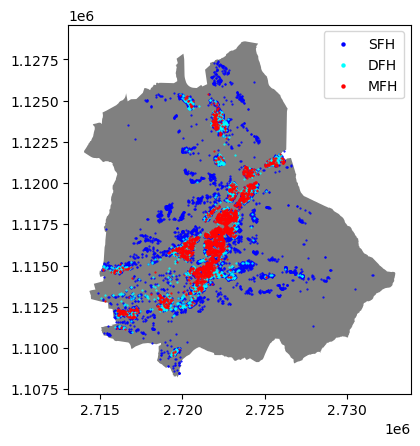

In [34]:
# Read the shp file and decode the Geopandas dataframe using the Swiss coordinates (epsg code: 2056)
SWISSTOPO_FILE = "swissboundaries3d_2023-01_2056_5728.shp/swissBOUNDARIES3D_1_4_TLM_BEZIRKSGEBIET.shp" #shapefile downloaded from https://www.swisstopo.admin.ch/fr/geodata/landscape/boundaries3d.html
FILE_PATH = MAP_DIRECTORY / SWISSTOPO_FILE
raw_limits = gpd.read_file(FILE_PATH)
district_limits = raw_limits.to_crs(epsg=2056)
district_selection = district_limits[district_limits.NAME == DISTRICT]
district_selection = district_selection[["NAME", "geometry"]]

axes = district_selection.plot(facecolor="grey")
AMB_RES_SFH_GEO.plot(ax=axes, color="blue",markersize=0.3, label = "SFH")
AMB_RES_DFH_GEO.plot(ax=axes, color="cyan",markersize=0.3, label = "DFH")
AMB_RES_MFH_GEO.plot(ax=axes, color="red",markersize=0.3, label = "MFH")
axes.legend(loc="upper right", markerscale=4)

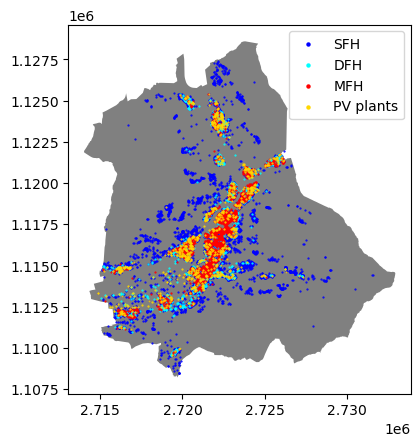

In [35]:
PLANT_DIRECTORY = DATA_DIRECTORY /'ElectricityProduction_EPSG2056'
plants =  gpd.read_file(PLANT_DIRECTORY / "ElectricityProductionPlants.gpkg") #file downloaded from https://www.geocat.ch/geonetwork/srv/eng/catalog.search#/metadata/e5a00bdb-5022-4856-ad4a-d1afe7bf38b0
plants_in_district = plants[plants.within(district_selection.at[54,"geometry"])]
PV_plants_in_district = plants_in_district.loc[plants_in_district["SubCategory"]== "subcat_2"] 

axes = district_selection.plot(facecolor="grey")
AMB_RES_SFH_GEO.plot(ax=axes, color="blue",markersize=0.3, label = "SFH")
AMB_RES_DFH_GEO.plot(ax=axes, color="cyan",markersize=0.3, label = "DFH")
AMB_RES_MFH_GEO.plot(ax=axes, color="red",markersize=0.3, label = "MFH")
PV_plants_in_district.plot(ax=axes, color="gold",markersize=0.3,label="PV plants")
axes.legend(loc="upper right", markerscale=4)

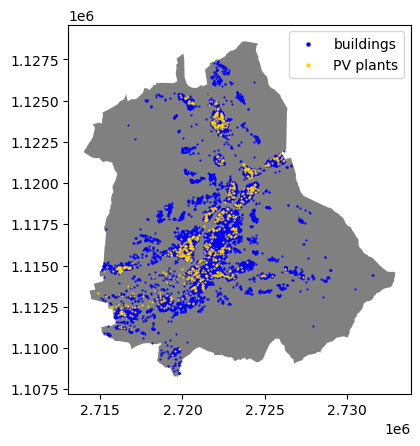

In [38]:
axes = district_selection.plot(facecolor="grey")
AMB_RES_GEO.plot(ax=axes, color="blue",markersize=0.3, label = "buildings")
PV_plants_in_district.plot(ax=axes, color="gold",markersize=0.3,label="PV plants")
axes.legend(loc="best", markerscale=4)